In [1]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import operation
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#modified wigner
def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy
    l = 5.0
    cutoff = rho.shape[0]
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)
    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))
    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi
    W = np.real(rho[0, 0]) * np.real(Wlist[0])
    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])
    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)
        W += np.real(rho[m, m] * Wlist[m])
        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            Wlist[n] = temp2
            W += 2 * np.real(rho[m, n] * Wlist[n])
    return Q, P, W / 2

In [35]:
def drawStateWigner(rho):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    X, P, W = wigner(rho)
    ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
    ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
    ax.set_axis_off()
    fig.show()

Quantum STATE LEARNING
Specific State(Outcome of Data) -> Evolve Quantum Circuit to create specific state

In [36]:
#Combining Rotation Gates, Displacement Gates, Kerr Gates <- Full Set of Gates to create ANY possible State
#How do we get the values for the gates of a specific state? -> Machine Learning

In [37]:
# Cutoff dimension
cutoff = 9

# Number of layers
depth = 15

# Number of steps in optimization routine performing gradient descent
reps = 50

# Learning rate
lr = 0.05

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

In [38]:
# set the random seed
tf.random.set_seed(42)

# squeeze gate
sq_r = tf.random.normal(shape=[depth], stddev=active_sd)
sq_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# displacement gate
d_r = tf.random.normal(shape=[depth], stddev=active_sd)
d_phi = tf.random.normal(shape=[depth], stddev=passive_sd)

# rotation gates
r1 = tf.random.normal(shape=[depth], stddev=passive_sd)
r2 = tf.random.normal(shape=[depth], stddev=passive_sd)

# kerr gate
kappa = tf.random.normal(shape=[depth], stddev=active_sd)

In [39]:
weights = tf.convert_to_tensor([r1, sq_r, sq_phi, r2, d_r, d_phi, kappa])
weights = tf.Variable(tf.transpose(weights))

In [40]:
# Single-mode Strawberry Fields program
prog = sf.Program(1)

# Create the 7 Strawberry Fields free parameters for each layer
sf_params = []
names = ["r1", "sq_r", "sq_phi", "r2", "d_r", "d_phi", "kappa"]

for i in range(depth):
    # For the ith layer, generate parameter names "r1_i", "sq_r_i", etc.
    sf_params_names = ["{}_{}".format(n, i) for n in names]
    # Create the parameters, and append them to our list ``sf_params``.
    sf_params.append(prog.params(*sf_params_names))

In [41]:
# layer architecture
@operation(1)
def layer(i, q):
    Rgate(sf_params[i][0]) | q
    Sgate(sf_params[i][1], sf_params[i][2]) | q
    Rgate(sf_params[i][3]) | q
    Dgate(sf_params[i][4], sf_params[i][5]) | q
    Kgate(sf_params[i][6]) | q
    return q

In [42]:
with prog.context as q:
    for k in range(depth):
        layer(k) | q[0]
    #15 copies of r gates * 2, s gates, d, gates, k gates

In [43]:
eng = sf.Engine("tf", backend_options={"cutoff_dim": cutoff})

In [44]:
target_state = np.zeros([cutoff])
target_state[1] = 1 #Fock State of 2
print(target_state)

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [45]:
def cost(weights):
    # Create a dictionary mapping from the names of the Strawberry Fields
    # free parameters to the TensorFlow weight values.
    flat_list = [item for sublist in sf_params for item in sublist]
    mapping = {p.name: w for p, w in zip(flat_list, tf.reshape(weights, [-1]))}

    # Run engine
    state = eng.run(prog, args=mapping).state

    # Extract the statevector
    ket = state.ket()

    # Compute the fidelity between the output statevector
    # and the target state.
    fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2

    # Objective function to minimize
    cost = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state) - 1)
    return cost, fidelity, ket

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)

Rep: 0 Cost: 0.9973 Fidelity: 0.0000


/Users/syed-mohammadraza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


None

Rep: 1 Cost: 0.3459 Fidelity: 0.4297


None

Rep: 2 Cost: 0.5866 Fidelity: 0.2695


None

Rep: 3 Cost: 0.4118 Fidelity: 0.4013


None

Rep: 4 Cost: 0.5630 Fidelity: 0.1953


None

Rep: 5 Cost: 0.4099 Fidelity: 0.4548


None

Rep: 6 Cost: 0.2258 Fidelity: 0.6989


None

Rep: 7 Cost: 0.3994 Fidelity: 0.5251


None

Rep: 8 Cost: 0.1787 Fidelity: 0.7421


None

Rep: 9 Cost: 0.3777 Fidelity: 0.5672


None

Rep: 10 Cost: 0.2201 Fidelity: 0.6140


None

Rep: 11 Cost: 0.3580 Fidelity: 0.6169


None

Rep: 12 Cost: 0.3944 Fidelity: 0.5549


None

Rep: 13 Cost: 0.3197 Fidelity: 0.5456


None

Rep: 14 Cost: 0.1766 Fidelity: 0.6878


None

Rep: 15 Cost: 0.1305 Fidelity: 0.7586


None

Rep: 16 Cost: 0.1304 Fidelity: 0.7598


None

Rep: 17 Cost: 0.1256 Fidelity: 0.7899


None

Rep: 18 Cost: 0.2366 Fidelity: 0.8744


None

Rep: 19 Cost: 0.1745 Fidelity: 0.7789


None

Rep: 20 Cost: 0.1093 Fidelity: 0.7965


/Users/syed-mohammadraza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


None

Rep: 21 Cost: 0.1848 Fidelity: 0.8335


None

Rep: 22 Cost: 0.0875 Fidelity: 0.8396


None

Rep: 23 Cost: 0.0993 Fidelity: 0.8628


None

Rep: 24 Cost: 0.1781 Fidelity: 0.9069


None

Rep: 25 Cost: 0.0620 Fidelity: 0.9115


None

Rep: 26 Cost: 0.2736 Fidelity: 0.8741


None

Rep: 27 Cost: 0.2465 Fidelity: 0.8898


None

Rep: 28 Cost: 0.0819 Fidelity: 0.8493


None

Rep: 29 Cost: 0.1841 Fidelity: 0.8074


None

Rep: 30 Cost: 0.1290 Fidelity: 0.8202


None

Rep: 31 Cost: 0.1419 Fidelity: 0.8794


None

Rep: 32 Cost: 0.1538 Fidelity: 0.8855


None

Rep: 33 Cost: 0.0711 Fidelity: 0.8688


None

Rep: 34 Cost: 0.1123 Fidelity: 0.8846


None

Rep: 35 Cost: 0.0390 Fidelity: 0.9240


None

Rep: 36 Cost: 0.0857 Fidelity: 0.9486


None

Rep: 37 Cost: 0.0470 Fidelity: 0.9613


None

Rep: 38 Cost: 0.0403 Fidelity: 0.9600


None

Rep: 39 Cost: 0.0820 Fidelity: 0.9583


None

Rep: 40 Cost: 0.0370 Fidelity: 0.9465


None

Rep: 41 Cost: 0.0386 Fidelity: 0.9475


None

Rep: 42 Cost: 0.0770 Fidelity: 0.9445


None

Rep: 43 Cost: 0.0373 Fidelity: 0.9576


None

Rep: 44 Cost: 0.0477 Fidelity: 0.9628


None

Rep: 45 Cost: 0.0749 Fidelity: 0.9730


None

Rep: 46 Cost: 0.0216 Fidelity: 0.9780


None

Rep: 47 Cost: 0.0636 Fidelity: 0.9808


None

Rep: 48 Cost: 0.0499 Fidelity: 0.9815


None

Rep: 49 Cost: 0.0249 Fidelity: 0.9804


None

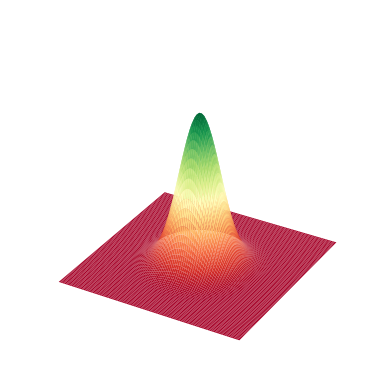

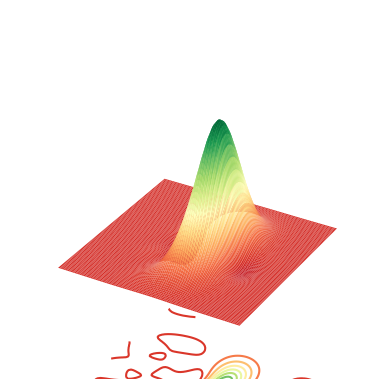

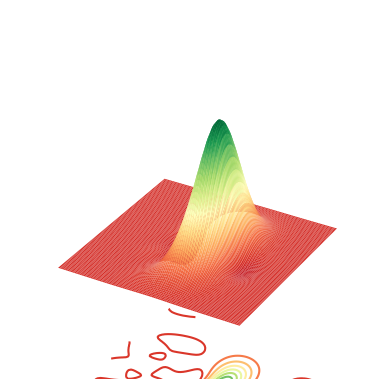

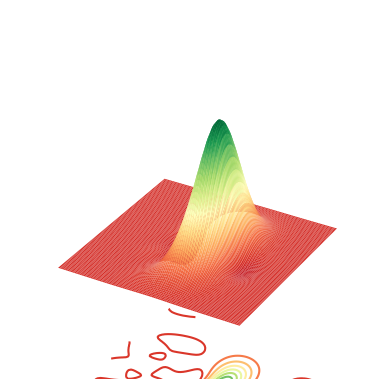

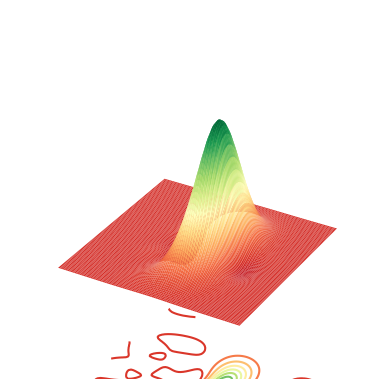

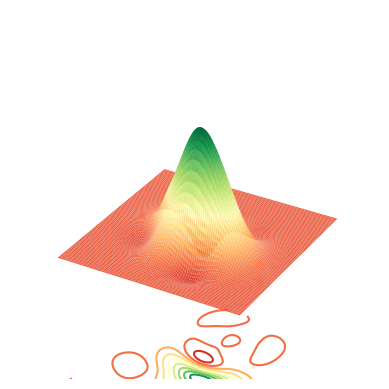

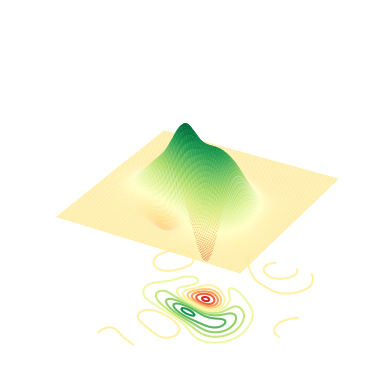

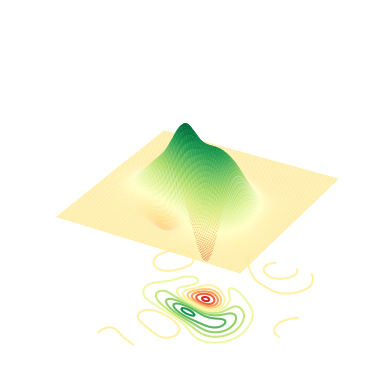

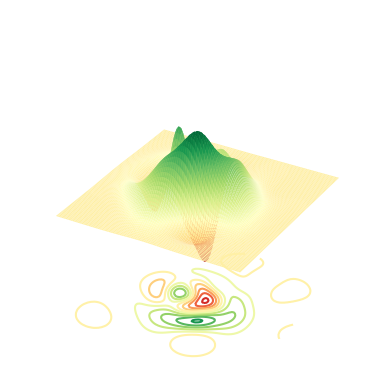

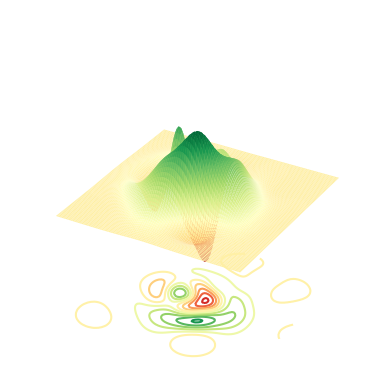

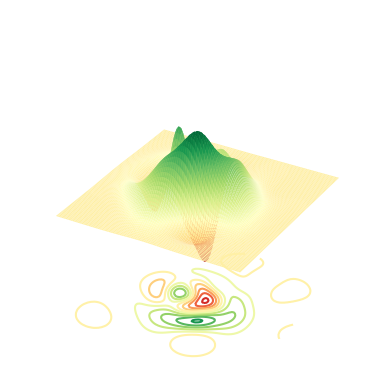

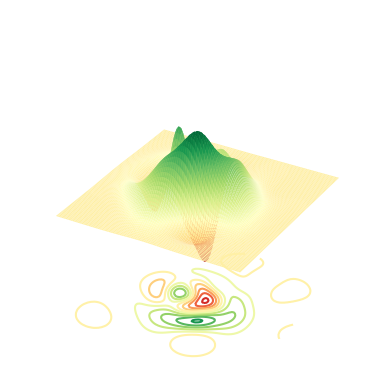

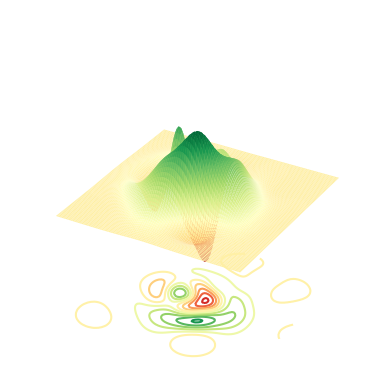

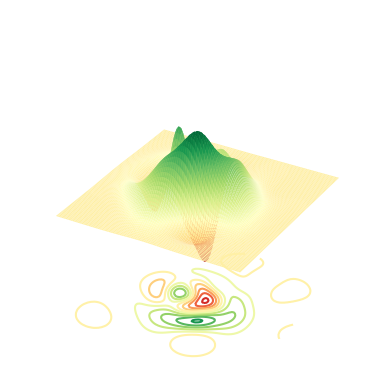

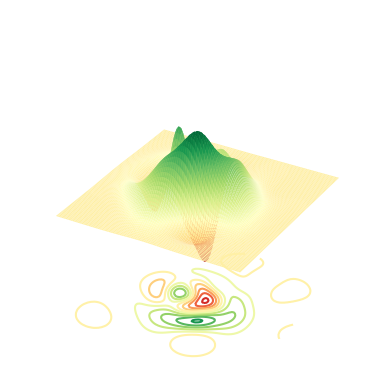

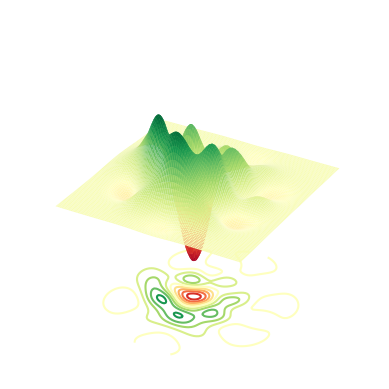

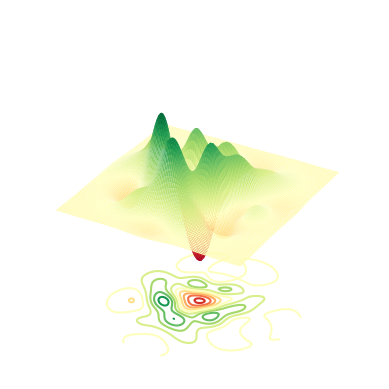

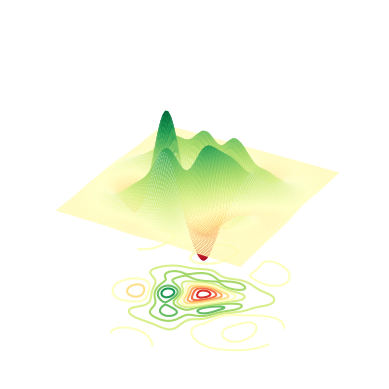

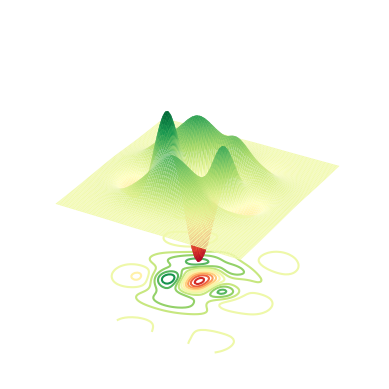

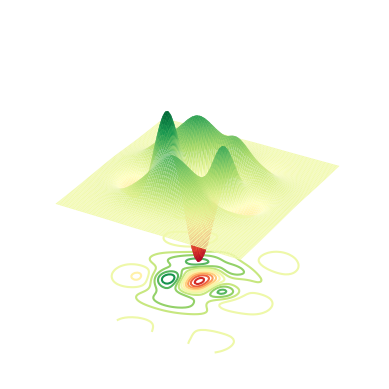

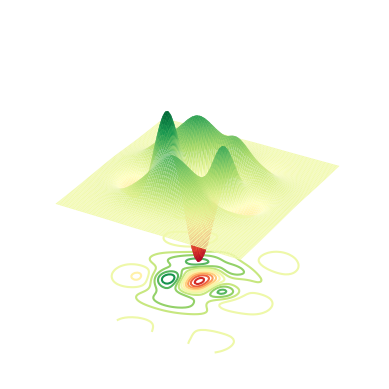

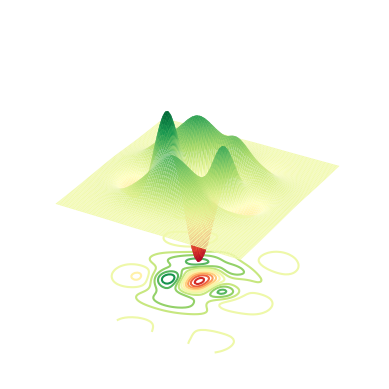

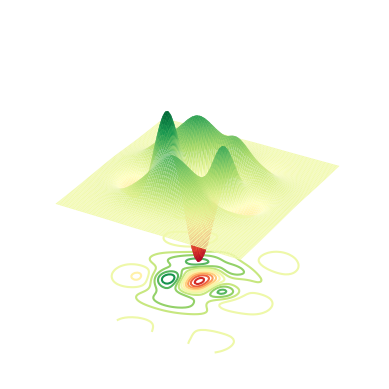

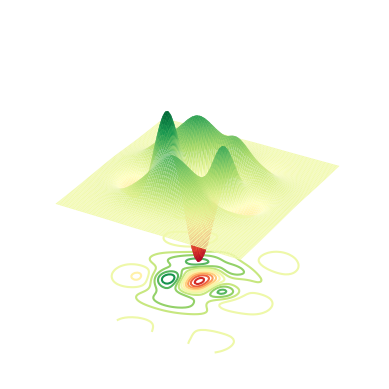

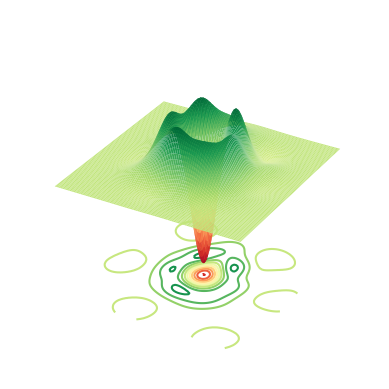

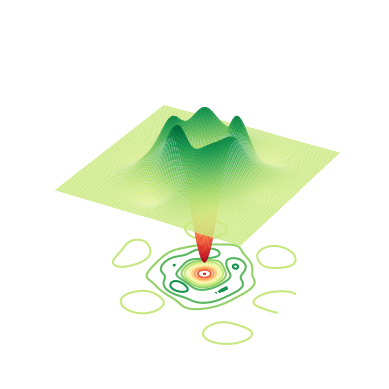

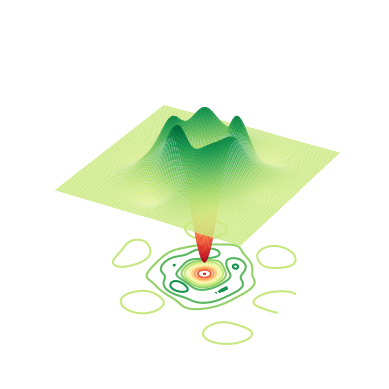

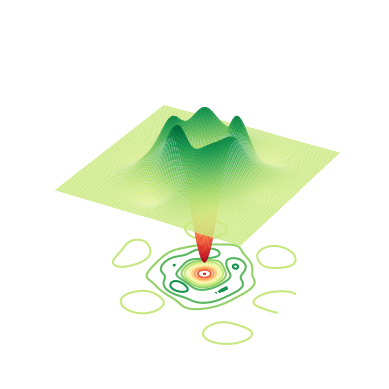

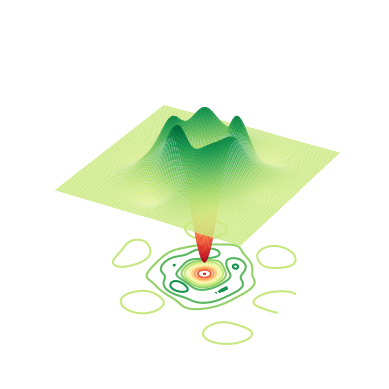

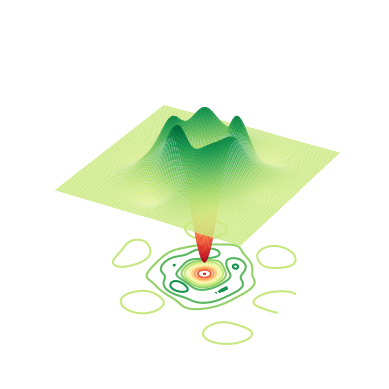

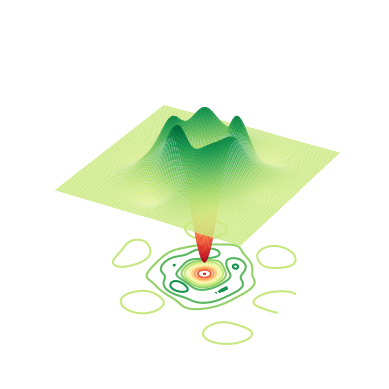

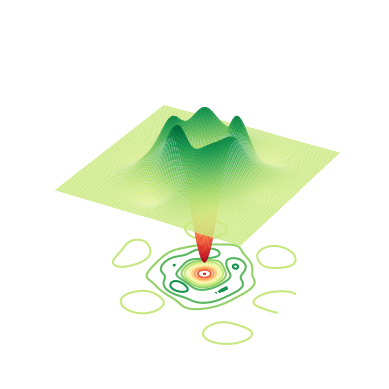

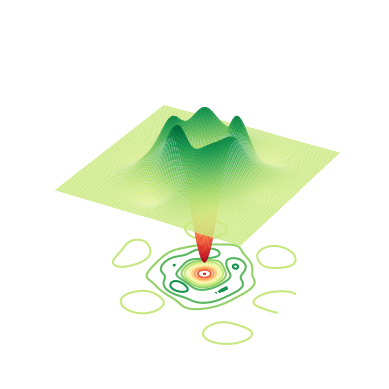

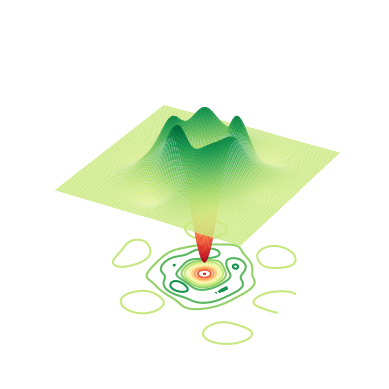

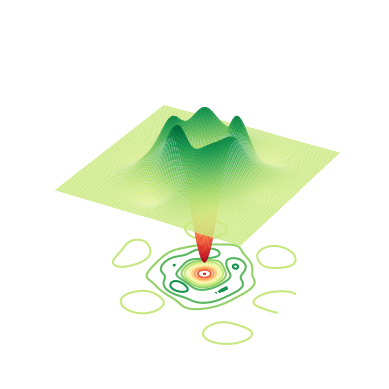

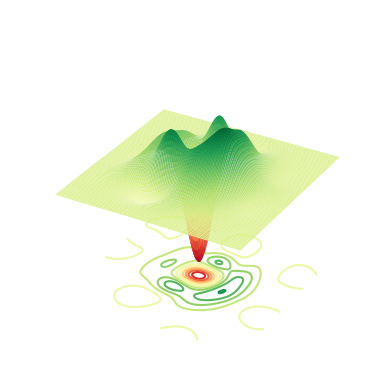

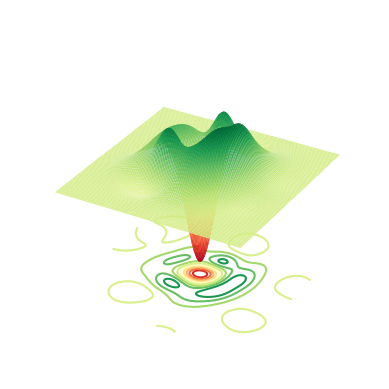

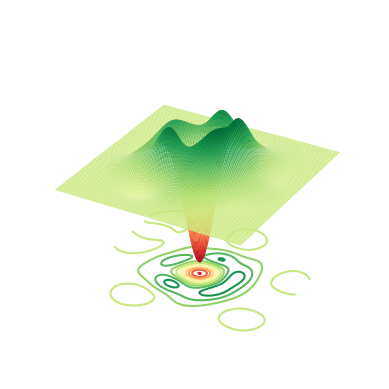

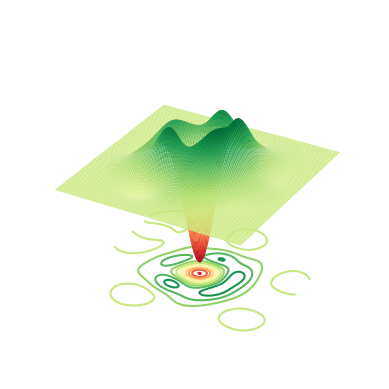

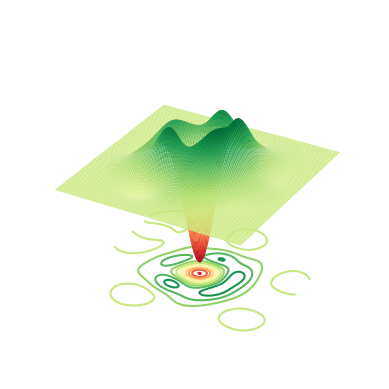

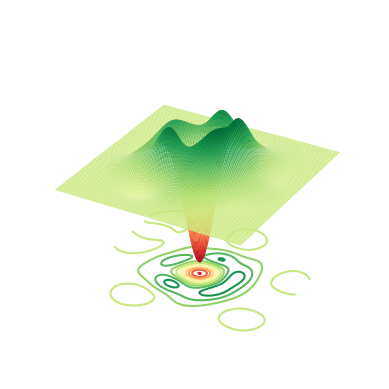

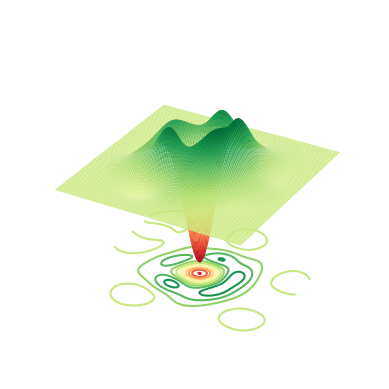

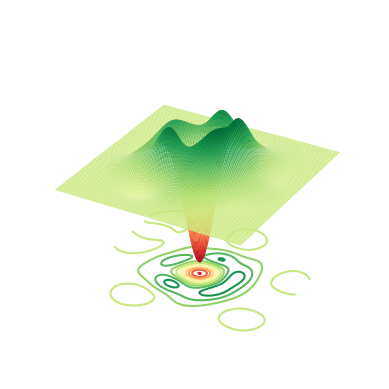

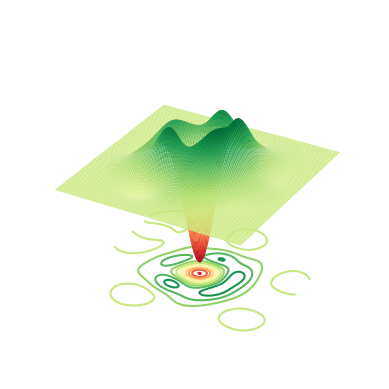

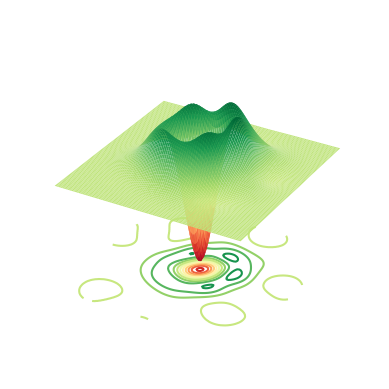

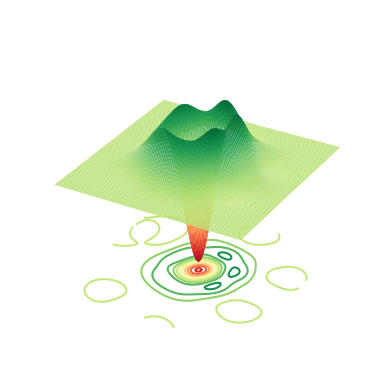

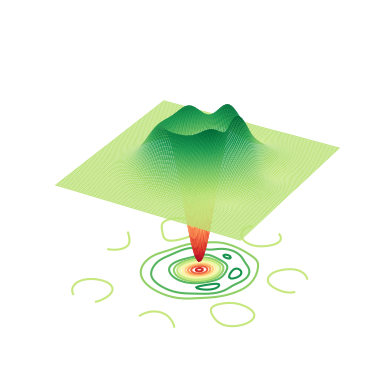

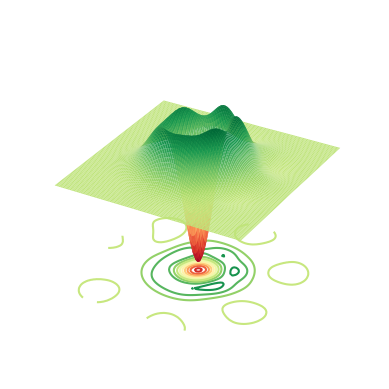

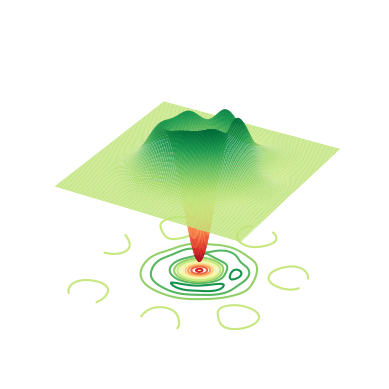

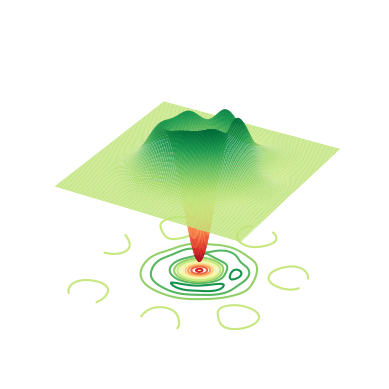

In [47]:
fid_progress = []
best_fid = 0

for i in range(reps):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss, fid, ket = cost(weights)

    # Stores fidelity at each step
    fid_progress.append(fid.numpy())

    if fid > best_fid:
        # store the new best fidelity and best state
        best_fid = fid.numpy()
        learnt_state = ket.numpy()

    # one repetition of the optimization
    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Prints progress at every rep
    if i % 1 == 0:
        print("Rep: {} Cost: {:.4f} Fidelity: {:.4f}".format(i, loss, fid))
    ###
    rho_learnt = np.outer(learnt_state, learnt_state.conj())
    display(drawStateWigner(rho_learnt))
    ###

Text(0.5, 0, 'Step')

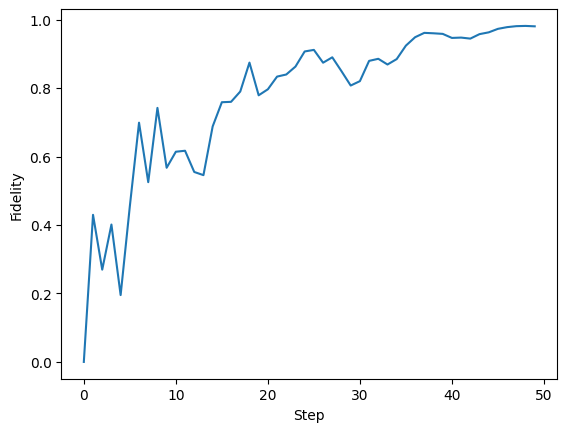

In [48]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
plt.style.use("default")

plt.plot(fid_progress)
plt.ylabel("Fidelity")
plt.xlabel("Step")

In [49]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

/Users/syed-mohammadraza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


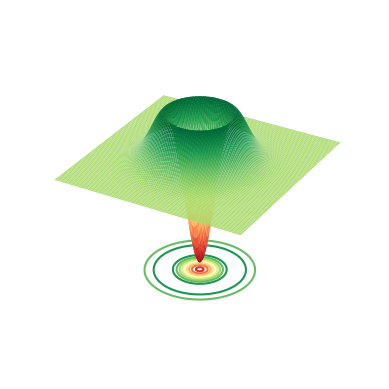

In [50]:
drawStateWigner(rho_target)

/Users/syed-mohammadraza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


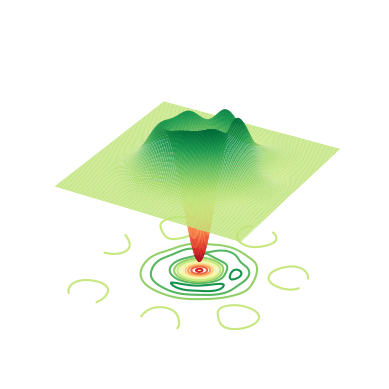

In [51]:
drawStateWigner(rho_learnt)

In [ ]:
#Quantum State -> Sq, R, D, [Kerr or Cubic Phase Gate] 